## Q1

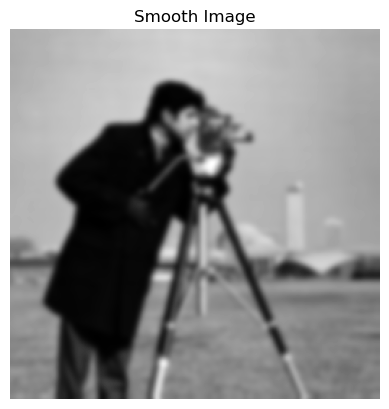

In [1]:
#Using 1 multipourpose convolve function

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
# Define the convolution function
def convolution(f, I):
    # Calculate padding dimensions
    row_padding = f.shape[0] // 2
    column_padding = f.shape[1] // 2
    pad_width = ((row_padding, row_padding), (column_padding, column_padding))
    I = np.pad(I, pad_width, mode='reflect')  # Apply padding to the input image
    new_matrix = [] # Initialize an empty matrix to store the convolved image
    for i in range(I.shape[0]- (f.shape[0] - 1)): # Iterate over the image to perform convolution
        new_row = []
        for j in range(I.shape[1] - (f.shape[1] - 1)):
            # Perform element-wise multiplication and summation
            z = np.sum(I[i:i + f.shape[0] , j:j + f.shape[1]] * f)                    
            new_row.append(z)
        new_matrix.append(new_row)
    return np.array(new_matrix)
# Define the Gaussian filter function
def gaussian_filter(sigma):
    size = int(6 * sigma + 1)

    center = (size // 2) + 1

    # Create 1D Gaussian filter
    filter_1d = np.zeros(size, dtype = float)
    for i in range(size):
        x = i - center
        filter_1d[i] = np.exp(-x**2 / (2 * sigma**2))

    # Normalize the filter
    filter_1d /= np.sum(filter_1d)

    return filter_1d

# Load the image
image_pil = Image.open('cameraman.png')
image_np = np.array(image_pil) 
img_array_float = image_np.astype(float)

# Define the derivative filters
x_filter = np.array([[-1, 0, 1]])
y_filter = np.array([[-1],[0], [1]])

# Generate Gaussian filter for smoothing
Gx = gaussian_filter(2)
Gx = Gx.reshape(1, Gx.shape[0])
Gy = Gx.T

# Apply Gaussian smoothing
I = convolution(Gy, img_array_float)
I = convolution(Gx, I)

# Display the smoothed image
plt.imshow(I, cmap='gray')
plt.title('Smooth Image')
plt.axis('off')

plt.show()

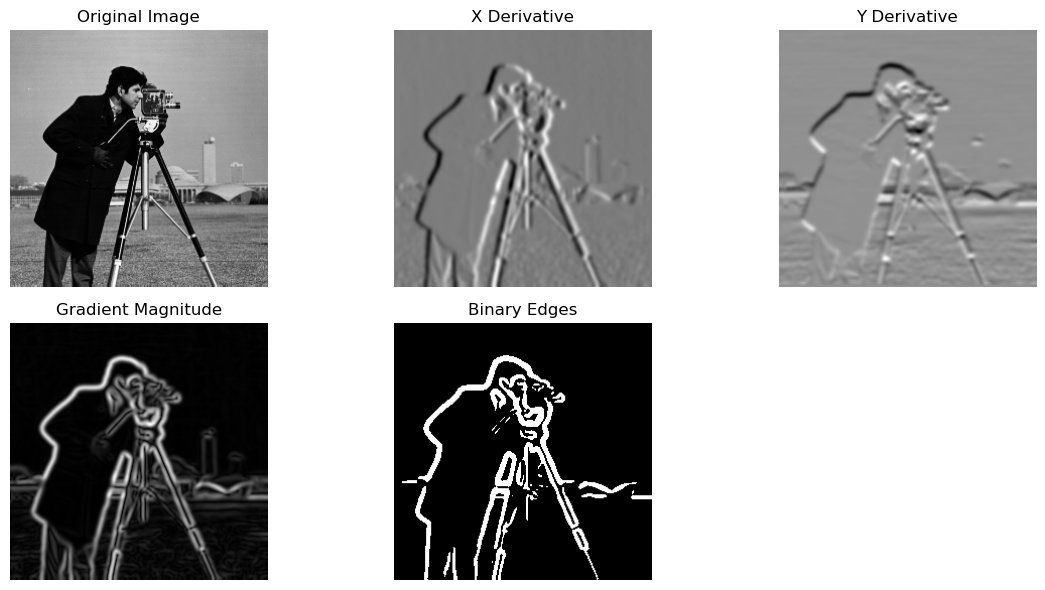

In [2]:
#First derivative
dx = convolution(x_filter, I)
dy = convolution(y_filter, I)
# Compute gradient magnitude
gradient_magnitude = np.sqrt(dx**2 + dy**2)
# Define threshold for binary edges
threshold = 25
binary_edges = np.where(gradient_magnitude > threshold, 255, 0).astype(np.uint8)
# print(binary_edges)
# Plot the images
plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
plt.imshow(image_np, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(dx, cmap='gray')
plt.title('X Derivative')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(dy, cmap='gray')
plt.title('Y Derivative')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(gradient_magnitude, cmap='gray')
plt.title('Gradient Magnitude')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(binary_edges, cmap='gray')
plt.title('Binary Edges')
plt.axis('off')

plt.tight_layout()
plt.show()

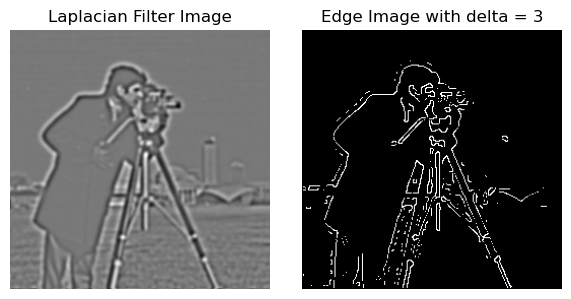

In [3]:
#second derivative or laplacian
# Define the Laplacian filter
laplacian_filter = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
# Apply Laplacian filter to the smoothed image
laplacian_image = convolution(laplacian_filter, I)
# Initialize edge image with zeros
height, width = laplacian_image.shape
edge_image = np.zeros_like(laplacian_image)
# Define delta threshold
delta = 3

# Iterate through each pixel in the Laplacian filtered image
for i in range(1, height - 1):
        for j in range(1, width - 1):
             # Check if the pixel value is positive
            if laplacian_image[i, j] > 0:
                # Extract neighboring pixels
                neighbors = laplacian_image[i-1:i+2, j-1:j+2]
                # Check if any neighbor has a negative value
                if np.any(neighbors < 0):
                    # Check if the maximum neighbor value minus the current pixel value exceeds the delta threshold
                    if np.max(neighbors) - laplacian_image[i, j] >= delta:
                        # Set the corresponding pixel in the edge image to 255
                        edge_image[i, j] = 255

# Plot the Laplacian filter image and the edge image
plt.figure(figsize=(6, 3))  # Adjust the figure size as needed
plt.subplot(1, 2, 1)  # First subplot
plt.imshow(laplacian_image, cmap='gray')
plt.title('Laplacian Filter Image')
plt.axis('off')

plt.subplot(1, 2, 2)  # Second subplot
plt.imshow(edge_image, cmap='gray')
plt.title('Edge Image with delta = 3')
plt.axis('off')

plt.tight_layout()  # Adjust the spacing between subplots for better readability
plt.show()

## Q2

In [4]:
from PIL import Image

# Load the original image
original_image = np.array(Image.open('animal-family-25.jpg').convert('L'), dtype=float)

# Load the template image
template_image = np.array(Image.open('animal-family-25-template.jpg').convert('L'), dtype=float)

# Calculate min, max, and mean value of the template image
mean_val = np.mean(template_image)
print("mean: ", mean_val)
# Normalize the template image
normalized_template = template_image - mean_val

# Now, the mean of the normalized template should be 0.0
mean_normalized_template = np.mean(normalized_template)
print("Mean of the normalized template:", mean_normalized_template)
# Get correlation-image
correlation_image =  convolution(normalized_template, original_image)
# Adjust correlation image to prevent saturation
adjusted_correlation_image = (correlation_image - np.min(correlation_image)) / (np.max(correlation_image) - np.min(correlation_image)) * 255


mean:  135.27836163836164
Mean of the normalized template: 5.5242035831962075e-15


In [5]:
# Fuction to calcuate connected white patches 
def connected_components(image):
    visited = np.zeros_like(image)
    labels = np.zeros_like(image)
    label_count = 1

    def dfs(row, col, label):
        if row < 0 or col < 0 or row >= image.shape[0] or col >= image.shape[1]:
            return
        if visited[row, col] or image[row, col] == 0:
            return
        visited[row, col] = 1
        labels[row, col] = label
        for dr, dc in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
            dfs(row + dr, col + dc, label)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if not visited[i, j] and image[i, j] == 255:
                dfs(i, j, label_count)
                label_count += 1

    return labels

Threshold:  160
Number of Matches (connected components): 6


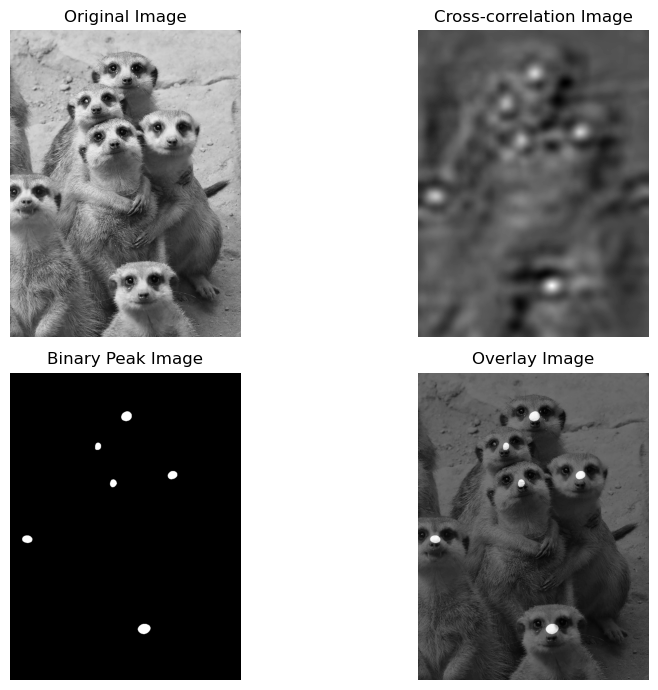

Threshold:  170
Number of Matches (connected components): 6


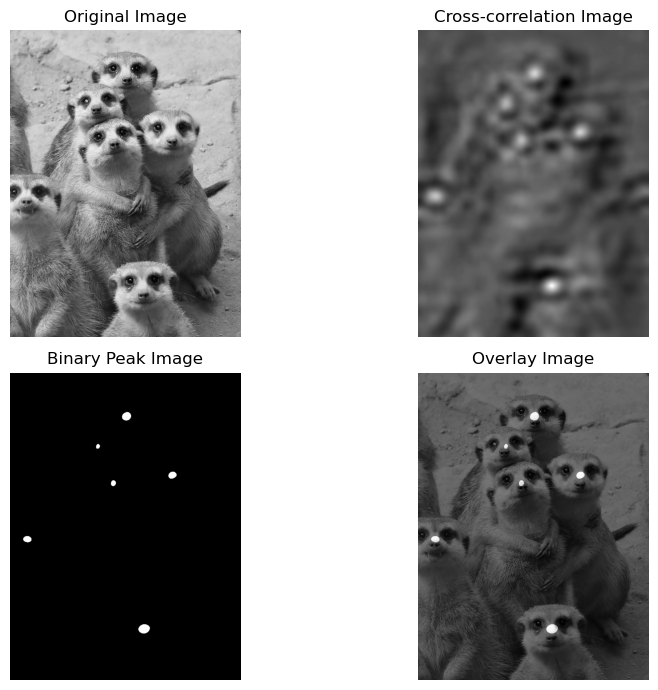

Threshold:  180
Number of Matches (connected components): 5


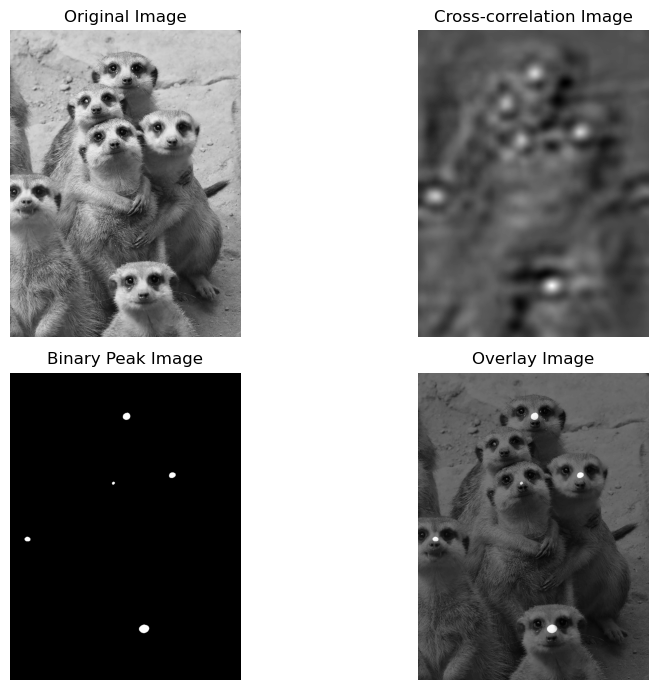

In [6]:
from scipy.ndimage import label

for i in range(3):
    threshold = 160 + (i * 10)
    binary_peak_image = (adjusted_correlation_image >= threshold).astype(np.uint8) * 255
    overlay_image = original_image + binary_peak_image
    print("Threshold: ", threshold)
#     labeled_image = connected_components(binary_peak_image)
    labeled_array, num_features = label(binary_peak_image)
#     num_white_patches = np.max(labeled_image)
    num_white_patches = num_features
    print("Number of Matches (connected components):", num_white_patches)
    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(10, 7))

    # Plot original image
    axes[0, 0].imshow(original_image, cmap='gray')
    axes[0, 0].set_title('Original Image')

    # Plot cross-correlation image
    axes[0, 1].imshow(adjusted_correlation_image, cmap='gray')
    axes[0, 1].set_title('Cross-correlation Image')

    # Plot binary peak image
    axes[1, 0].imshow(binary_peak_image, cmap='gray')
    axes[1, 0].set_title('Binary Peak Image')

    # Plot overlay image
    axes[1, 1].imshow(overlay_image, cmap='gray')
    axes[1, 1].set_title('Overlay Image')

    # Hide axes
    for ax in axes.flatten():
        ax.axis('off')

    plt.tight_layout()
    plt.show()

## Q3

In [7]:
# All Steps in Q2 together:
def find_in_image(original_image, template_image, limit):
    mean_val = np.mean(template_image)
    normalized_template = template_image - mean_val
    mean_normalized_template = np.mean(normalized_template)
    correlation_image =  convolution(normalized_template, original_image)
    print(correlation_image.shape)
    adjusted_correlation_image = (correlation_image - np.min(correlation_image)) / (np.max(correlation_image) - np.min(correlation_image)) * 255
    threshold = limit
    binary_peak_image = (adjusted_correlation_image >= threshold).astype(np.uint8) * 255
    overlay_image = original_image + binary_peak_image
    # labeled_image = connected_components(binary_peak_image)
    labeled_array, num_features = label(binary_peak_image)
    # num_white_patches = np.max(labeled_image)
    num_white_patches = num_features
    print("Number of Matches (connected components):", num_white_patches)
    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    # Plot original image
    axes[0, 0].imshow(original_image, cmap='gray')
    axes[0, 0].set_title('Original Image')

    # Plot cross-correlation image
    axes[0, 1].imshow(adjusted_correlation_image, cmap='gray')
    axes[0, 1].set_title('Cross-correlation Image')

    # Plot binary peak image
    axes[1, 0].imshow(binary_peak_image, cmap='gray')
    axes[1, 0].set_title('Binary Peak Image')

    # Plot overlay image
    axes[1, 1].imshow(overlay_image, cmap='gray')
    axes[1, 1].set_title('Overlay Image')

    # Hide axes
    for ax in axes.flatten():
        ax.axis('off')

    plt.tight_layout()
    plt.show()

Number of Matches (connected components): 1


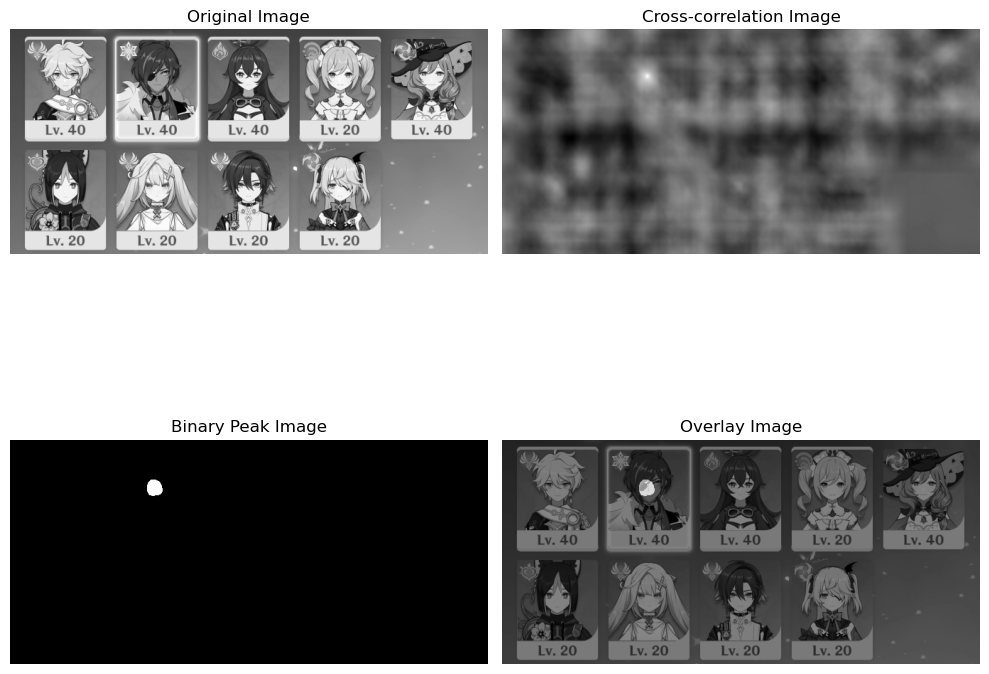

In [88]:
original_image = np.array(Image.open('image_3.png').convert('L'), dtype=float)
template_image = np.array(Image.open('image_2.png').convert('L'), dtype=float)
find_in_image(original_image, template_image, 170)

(912, 1077)
Number of Matches (connected components): 1


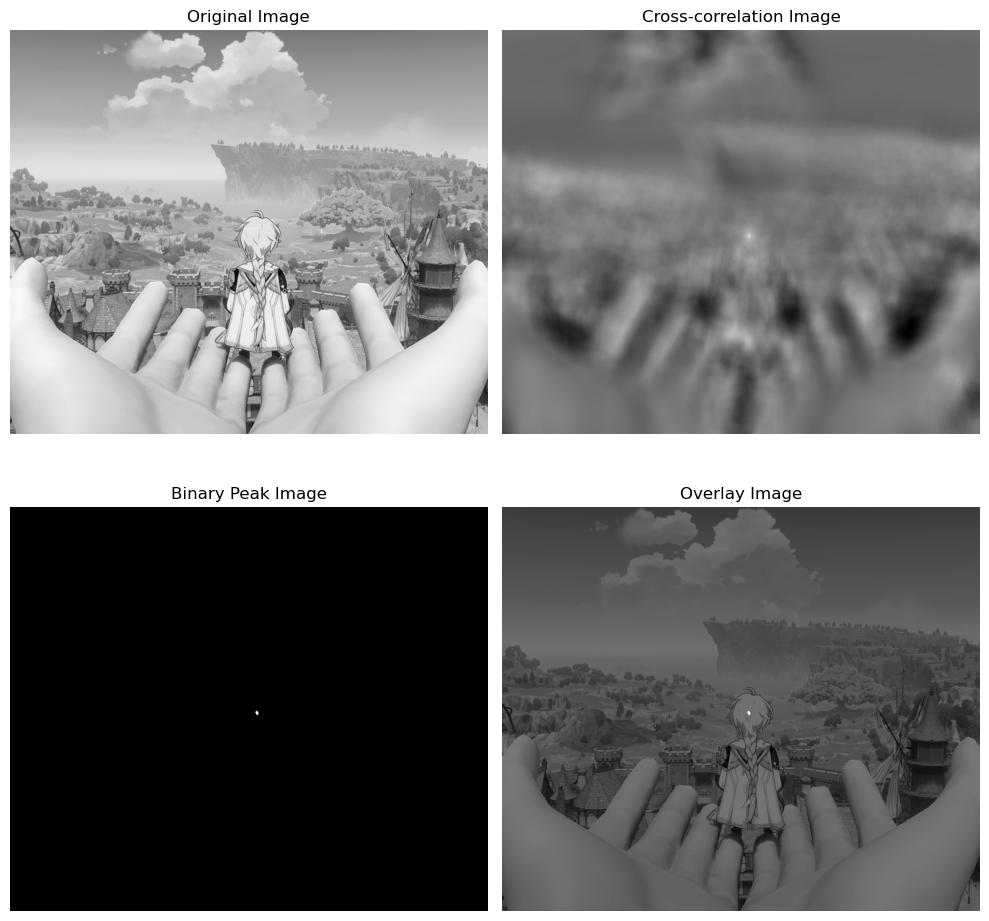

In [117]:
original_image = np.array(Image.open('image_4.png').convert('L'), dtype=float)
template_image = np.array(Image.open('image_1.png').convert('L'), dtype=float)
find_in_image(original_image, template_image, 190)